![NCIA-start](NCIA_Images\start.png)

**Capítulo 7 – Redução de Dimensionalidade**

# Setup

Este projeto requer Python 3.10 ou superior:

In [1]:
import sys

assert sys.version_info >= (3, 10)

Também requer Scikit-Learn ≥ 1.5.2:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.5.2")

Como fizemos nos capítulos anteriores, vamos definir os tamanhos de fonte padrão para deixar as figuras mais bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# PCA

Este capítulo começa com várias figuras para explicar os conceitos de PCA e Aprendizagem de Variedade (Manifold Learning). Abaixo está o código para gerar essas figuras. Você pode pular diretamente para a seção [Componentes Principais](#Principal-Components) abaixo, se desejar.

Vamos gerar um pequeno conjunto de dados 3D. É uma forma oval, rotacionada no espaço 3D, com pontos distribuídos de forma desigual e com bastante ruído:

### Geração de dados sintéticos em 3D

Nesta célula criamos um conjunto de dados artificial em três dimensões:
- Usamos **NumPy** para gerar pontos e adicionar ruído.
- Utilizamos **scipy.spatial.transform.Rotation** para aplicar uma rotação 3D.
- Os passos são:
  - Inicializar uma matriz de zeros para armazenar os pontos.
  - Gerar ângulos aleatórios com distribuição não uniforme.
  - Criar pontos em formato oval (usando seno e cosseno).
  - Adicionar ruído gaussiano.
  - Aplicar rotação em torno de um vetor definido.
  - Transladar (deslocar) os pontos no espaço.
O resultado é um conjunto de 60 pontos que simulam dados 3D realistas com ruído e rotação.


In [4]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
rng = np.random.default_rng(seed=42)
angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * rng.standard_normal((m, 3))  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

Agora temos `X`, um array de dimensão `(60, 3)` representando 60 pontos 3D:
- Os pontos formam uma estrutura oval ruidosa.
- Sofreram rotação espacial e deslocamento.
Esse conjunto servirá como base para experimentos de redução de dimensionalidade ou visualização.


### PCA: projeção de 3D para 2D

Aqui usamos **PCA** para reduzir os dados de 3D para 2D e depois projetamos de volta em 3D.  
O código constrói o plano de projeção e mostra os pontos originais, suas projeções e as linhas de ligação.  


Plote o conjunto de dados 3D, com o plano de projeção.

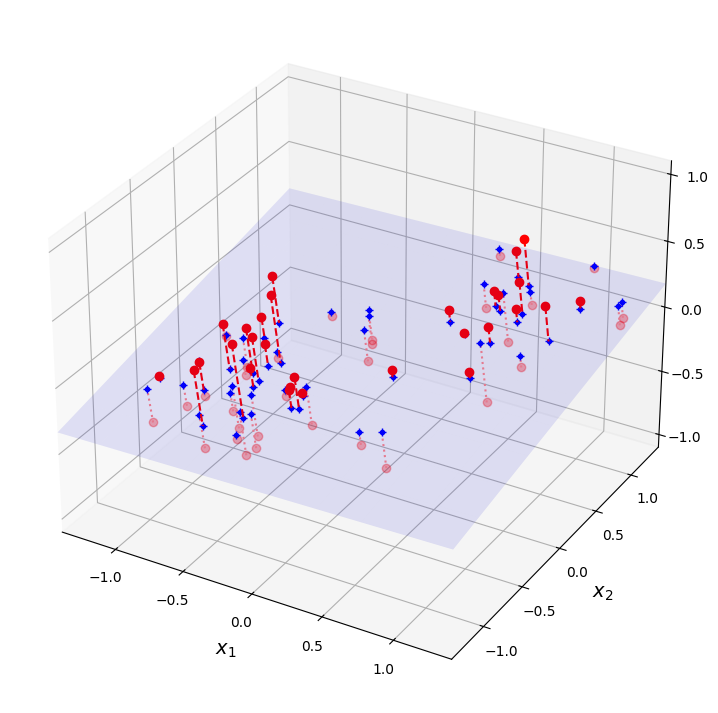

In [5]:
# extra code – this cell generates Figure 7–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])


plt.show()

O gráfico mostra os pontos em 3D, o plano azul do PCA e como cada ponto é projetado nele.  


### Visualização dos dados reduzidos pelo PCA em 2D


- Usamos o resultado do **PCA** (`X2D`) que contém os dados originais em apenas **2 dimensões**.
- Plotamos os pontos em azul (`b+` e `b.`) no novo sistema de coordenadas.
- Os eixos $z_1$ e $z_2$ representam as duas **componentes principais**, isto é, as direções que explicam a maior variação dos dados.
- As setas desenhadas indicam essas direções no plano 2D.
O objetivo é mostrar como o PCA redefine o espaço de eixos para capturar a essência dos dados.  


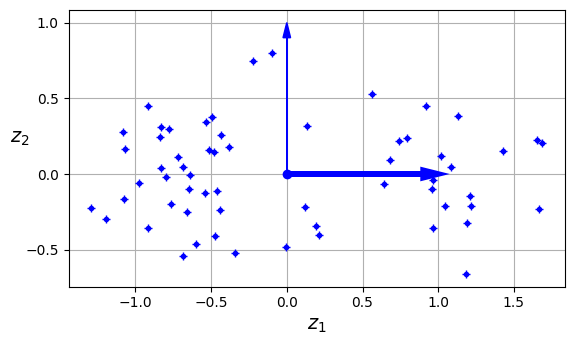

In [6]:
# extra code – this cell generates Figure 7–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

O gráfico exibe os pontos transformados no espaço 2D do PCA, já alinhados com as direções de maior variância ($z_1$ e $z_2$).  
Isso ilustra como o PCA não apenas reduz a dimensionalidade, mas também cria um novo sistema de coordenadas baseado nas componentes principais.  


### Conjunto de dados Swiss Roll

Nesta célula:
- Usamos `make_swiss_roll` para gerar um dataset 3D em forma de **rolo suíço** (uma superfície curva enrolada).
- Cada ponto recebe uma cor baseada em sua posição ao longo do rolo (`t`).
- O gráfico 3D é exibido com coloração gradual, ajudando a visualizar a estrutura não linear.
Esse dataset é muito usado para demonstrar **técnicas de redução de dimensionalidade em dados de múltiplas dimensões**.  


In [7]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

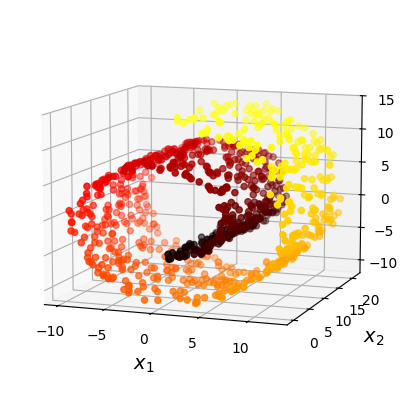

In [8]:
# extra code – this cell generates Figure 7–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

O gráfico mostra o **Swiss Roll**: pontos em 3D formando uma superfície enrolada, com cores indicando a posição ao longo da curva.  
É um exemplo clássico de dados que vivem em uma **variedade não linear (manifold)**.  


### Projeção do Swiss Roll em 2D

Nesta célula:
- Mostramos duas formas de visualizar o dataset **Swiss Roll**:
  - **Esquerda:** projeção direta no plano $(x_1, x_2)$, que ainda mantém a sobreposição da estrutura enrolada.
  - **Direita:** mapeamento usando a coordenada intrínseca $t$ (marcada como $z_1$), revelando a verdadeira ordem linear dos pontos.
O objetivo é destacar que projeções simples podem esconder a estrutura, enquanto a parametrização correta ($t$) revela o manifold.  


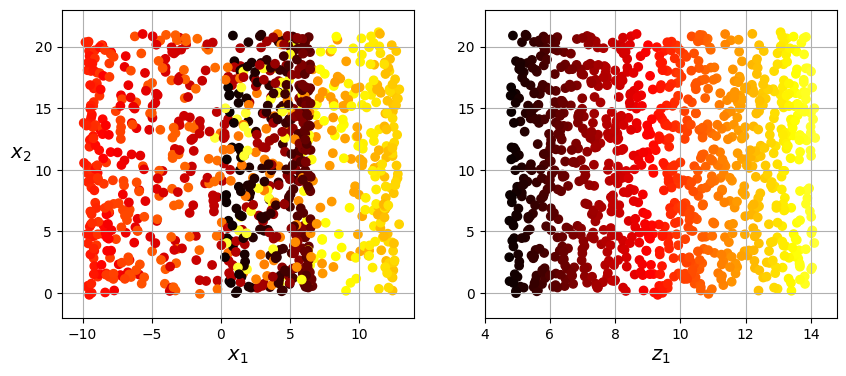

In [9]:
# extra code – this cell generates plots for Figure 7–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

Os gráficos exibem:
- À esquerda, o Swiss Roll achatado no plano $(x_1, x_2)$, ainda enrolado.
- À direita, a dimensão intrínseca $t$ versus $x_2$, mostrando claramente o desenrolar da superfície.  
Isso ilustra como dados em alta dimensão podem ter **estruturas internas mais simples** quando vistos no espaço certo.  


### Classificação no Swiss Roll: espaço original vs. espaço não linear

Nesta célula:
- Definimos uma **classe positiva e negativa** de pontos no Swiss Roll.
- Primeiro, usamos uma regra simples no espaço 3D ($x_1 > 5$) e mostramos o plano separador.
- Em seguida, representamos os mesmos pontos no espaço das coordenadas intrínsecas ($z_1, z_2$), onde a separação fica mais clara.
- Depois, aplicamos uma **fronteira de decisão não linear** baseada em $t$ e $x_2$, que separa melhor as classes.
O objetivo é mostrar que dados em alta dimensão podem parecer difíceis de separar, mas em um espaço transformado ou adequado a fronteira pode se tornar simples.  


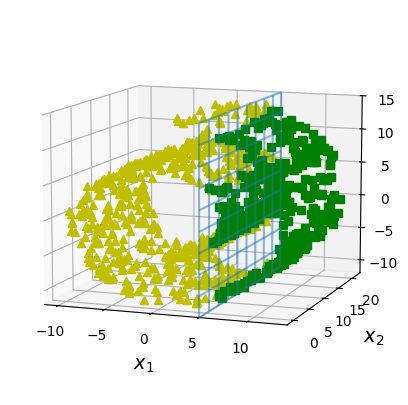

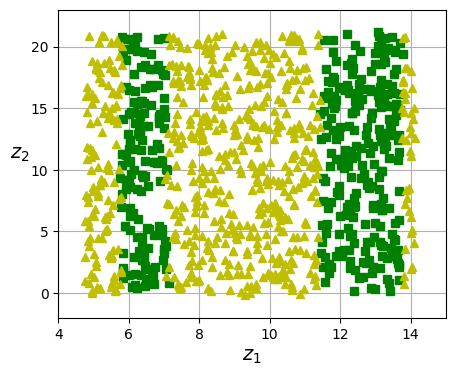

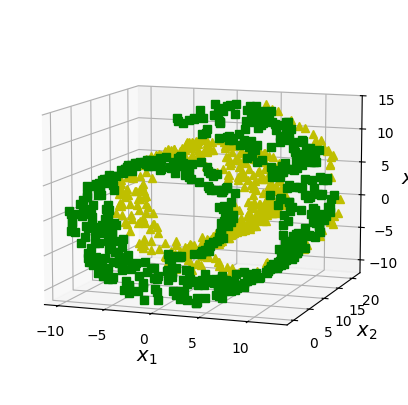

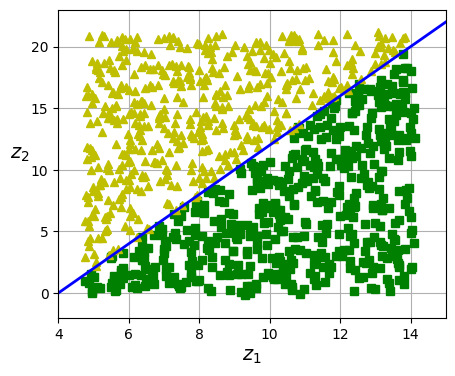

In [10]:
# extra code – this cell generates plots for Figure 7–6
    
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

Os gráficos exibem:
- No espaço 3D original, a separação pode exigir planos ou curvas complicadas.
- No espaço $(z_1, z_2)$, as classes ficam bem distribuídas e a fronteira de decisão pode ser traçada de forma simples.
Isso ilustra como **transformações de espaço** ajudam a resolver problemas de classificação em dados complexos.  


### Projeções de dados em diferentes direções

Nesta célula:
- Geramos pontos 2D alongados e rotacionados.
- Definimos três direções ($u_1, u_2, u_3$) para projetar os dados.
- Cada projeção reduz os pontos a uma dimensão, mostrando como a **variância dos dados** depende da direção escolhida.
A ideia é ilustrar o conceito central do **PCA**: escolher a direção que preserva mais informação (maior variância).  


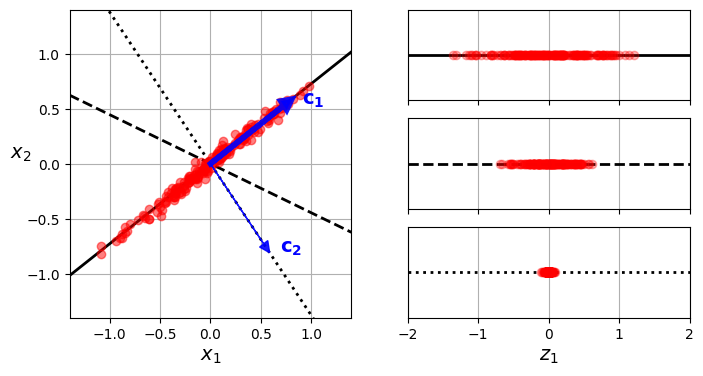

In [11]:
# extra code – this cell generates Figure 7–7

angle = np.pi / 5
stretch = 5
m = 200

rng = np.random.default_rng(seed=3)
X_line = rng.standard_normal((m, 2)) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()


plt.show()

O gráfico mostra:
- À esquerda, os pontos no espaço 2D com as direções de projeção desenhadas.
- À direita, os dados projetados em cada direção.
Percebe-se que a projeção em $u_1$ mantém maior espalhamento, enquanto outras direções comprimem a variância.  


## Componentes Principais

### Decomposição SVD para encontrar componentes principais

Nesta célula:
- Centralizamos os dados (`X_centered`) subtraindo a média.
- Aplicamos **SVD (Singular Value Decomposition)** para decompor a matriz.
- De `Vt`, extraímos os vetores `c1` e `c2`, que correspondem às duas primeiras **componentes principais** do PCA.  


In [12]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Agora temos `c1` e `c2`, que representam as direções de maior variância nos dados originais.  
Eles formam a base do novo espaço usado pelo PCA.  


Nota: em princípio, o algoritmo de fatoração SVD retorna três matrizes, **U**, **Σ** e **V**, tal que **X** = **UΣV**<sup>⊺</sup>, onde **U** é uma matriz _m_ × _m_, **Σ** é uma matriz _m_ × _n_, e **V** é uma matriz _n_ × _n_. Mas a função `svd()` retorna **U**, **s** e **V**<sup>⊺</sup>. **s** é o vetor contendo todos os valores na diagonal principal das _n_ linhas superiores de **Σ**. Como **Σ** é preenchido com zeros em outros lugares, você pode reconstruí-lo facilmente a partir de **s**, assim:

In [13]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

A verificação confirma que a matriz centralizada pode ser exatamente reconstruída usando `U`, `Σ` e `Vt`.  


## Projetando para d Dimensões


- Selecionamos as duas primeiras linhas de `Vt` (as direções principais) e transpostas em `W2`.
- Projetamos os dados centralizados (`X_centered`) sobre esse subespaço.
- O resultado `X2D` é a representação dos dados em **2 dimensões**, obtida via PCA manualmente com SVD.  


In [14]:
W2 = Vt[:2].T
X2D = X_centered @ W2

Agora temos `X2D`, os dados originais reduzidos para 2D, preservando ao máximo a variância.  


## Usando Scikit-Learn

Com Scikit-Learn, PCA é realmente trivial. Ele até cuida da centralização da média para você:


- Criamos um objeto `PCA` pedindo 2 componentes principais.
- Usamos `fit_transform` para ajustar o modelo aos dados `X` e reduzi-los diretamente para 2 dimensões.
Esse é o uso direto do **PCA** com a implementação do Scikit-Learn.  


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

Agora `X2D` contém os dados originais representados em 2D, extraídos automaticamente pelo PCA.  


In [16]:
pca.components_

array([[ 0.66824153,  0.73208333,  0.13231495],
       [ 0.74374636, -0.66151587, -0.09611511]])

O resultado mostra uma matriz onde cada linha é uma **componente principal**:  
- A primeira linha é a direção de maior variância.  
- A segunda linha é a segunda direção ortogonal, capturando a variância restante.  


## Razão da Variância Explicada

Now let's look at the explained variance ratio:

In [17]:
pca.explained_variance_ratio_

array([0.82279334, 0.10821224])

A primeira dimensão explica cerca de 76% da variância, enquanto a segunda explica cerca de 15%.

Ao projetar para 2D, perdemos cerca de 9% da variância:

In [18]:
1 - pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.06899442237323172)

## Escolhendo o Número Certo de Dimensões

- Carregamos o **MNIST** (imagens de dígitos escritos à mão).
- Separamos em treino (60.000) e teste (10.000).
- Ajustamos um PCA sem definir o número de componentes.
- Calculamos a soma acumulada da variância explicada (`cumsum`).
- Encontramos o menor número de componentes `d` que preserva **95% da variância**.  


In [19]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

O valor de `d` é **154**, ou seja, apenas 154 componentes principais já conseguem reter 95% da informação do MNIST, reduzindo bastante a dimensionalidade.  


In [20]:
d

np.int64(154)

- Criamos um `PCA` com `n_components=0.95`, pedindo que o modelo escolha quantos componentes são necessários para reter **95% da variância**.  
- Ajustamos o PCA aos dados de treino (`fit_transform`), obtendo `X_reduced`, a versão reduzida do dataset.  
- Consultamos `pca.n_components_` (quantos componentes foram usados) e somamos a variância explicada (`explained_variance_ratio_.sum()`).  


In [21]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [22]:
pca.n_components_

np.int64(154)

In [23]:
pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.9501960192613033)

O PCA escolheu automaticamente cerca de **154 componentes**, preservando ~95% da variância total dos dados.  
Assim, reduzimos a dimensionalidade mantendo quase toda a informação relevante.  


- Plotamos a **soma acumulada da variância explicada** pelo PCA em função do número de dimensões.  
- Adicionamos linhas de referência para 95% da variância e marcamos o ponto de corte `d`.  
- Indicamos o "cotovelo" da curva, onde aumentar o número de componentes passa a trazer pouco ganho adicional.  


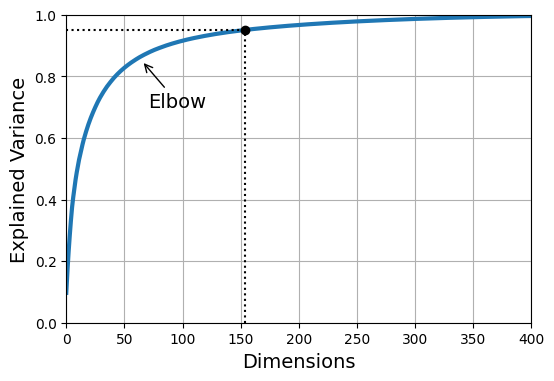

In [24]:
# extra code – this cell generates Figure 7–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

O gráfico mostra que cerca de **154 dimensões** já preservam 95% da variância.  
O "cotovelo" indica o ponto ideal de redução de dimensionalidade sem grande perda de informação.  


### Pipeline PCA + Random Forest com busca de hiperparâmetros

Nesta célula:
- Criamos um **pipeline** com duas etapas:  
  1. **PCA** para reduzir a dimensionalidade.  
  2. **RandomForestClassifier** para classificação.  
- Definimos uma distribuição de parâmetros para busca:  
  - `pca__n_components`: número de componentes principais (10 a 80).  
  - `randomforestclassifier__n_estimators`: número de árvores (50 a 500).  
- Usamos `RandomizedSearchCV` para testar 10 combinações aleatórias de hiperparâmetros com validação cruzada (cv=3).  
- Treinamos o modelo em um subconjunto de 1000 imagens do MNIST.  


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'pca__n_components': array([10, 11... 78, 79]), 'randomforestclassifier__n_estimators': array([ 50, ...97, 498, 499])}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


O modelo resultante é um classificador que combina **redução de dimensionalidade (PCA)** e **árvores de decisão em ensemble (Random Forest)**, com hiperparâmetros ajustados automaticamente via busca aleatória.  


In [26]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


### Pipeline PCA + SGDClassifier com Grid Search

Nesta célula:
- Montamos um **pipeline** com:  
  1. **PCA** para redução de dimensionalidade.  
  2. **SGDClassifier** (gradiente descendente estocástico) para classificação.  
- Definimos um **grid de parâmetros** variando `pca__n_components` de 10 a 79.  
- Usamos `GridSearchCV` para testar todas as combinações com validação cruzada (cv=3).  
- Treinamos o modelo em 1000 imagens do MNIST.  


In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'pca__n_components': array([10, 11... 78, 79])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,np.int64(76)


O resultado é um classificador linear treinado após redução de dimensionalidade, com o número de componentes principais escolhido automaticamente pelo **Grid Search**.  


In [28]:
grid_search.best_params_

{'pca__n_components': np.int64(76)}

## PCA para Compressão


- Criamos um `PCA` com `n_components=0.95`, pedindo que o modelo mantenha **95% da variância**.  
- Aplicamos `fit_transform` nos dados de treino (`X_train`), obtendo `X_reduced`, uma versão reduzida do dataset.  


In [29]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

O resultado é `X_reduced`, que contém o MNIST em uma dimensionalidade muito menor, mas ainda preservando a maior parte da informação (95% da variância).  


In [30]:
X_recovered = pca.inverse_transform(X_reduced)

- Comparamos imagens do MNIST **originais** e suas versões **comprimidas e reconstruídas** após aplicar PCA.  
- As imagens reconstruídas vêm de `X_recovered`, obtido projetando e depois invertendo a transformação PCA.  
- O objetivo é visualizar o efeito da redução de dimensionalidade sobre a qualidade das imagens.  

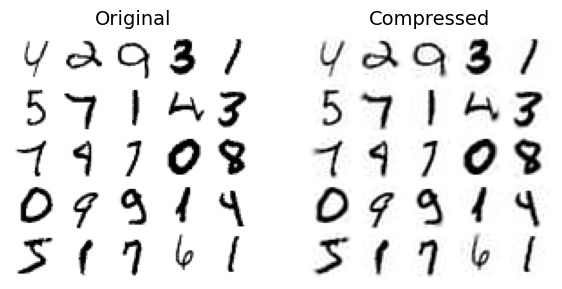

In [31]:
# extra code – this cell generates Figure 7–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")



O gráfico mostra lado a lado dígitos originais e comprimidos.  
Apesar da perda de detalhes, as imagens reconstruídas mantêm a estrutura suficiente para reconhecimento, provando a eficiência do PCA na **compressão de dados**.  


## PCA Aleatório

- Criamos um `PCA` com `n_components=154`, o número necessário para manter ~95% da variância do MNIST.  
- Usamos o parâmetro `svd_solver="randomized"`, que aplica um método aproximado, mais rápido em grandes conjuntos de dados.  
- Reduzimos os dados de treino (`X_train`) para obter `X_reduced`.  

In [32]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

O resultado é `X_reduced`, uma versão do MNIST reduzida para 154 dimensões, obtida de forma mais eficiente graças ao solver aleatório.  


## PCA Incremental

- Usamos **IncrementalPCA**, que permite treinar o PCA em **batches** (lotes), útil para grandes conjuntos de dados.  
- Dividimos `X_train` em 100 partes com `np.array_split`.  
- Para cada lote, aplicamos `partial_fit`, ajustando o modelo de forma incremental.  
- No final, transformamos todo `X_train` em `X_reduced`.  
markdown
Copiar código


In [33]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Agora temos `X_reduced`, os dados do MNIST reduzidos para 154 dimensões usando **Incremental PCA**, adequado para datasets grandes que não cabem na memória de uma só vez.  


**Usando a classe `memmap` do NumPy – um mapa de memória para uma matriz armazenada em um arquivo binário no disco.**

Vamos criar a instância `memmap`, copiar o conjunto de treinamento MNIST para ela e chamar `flush()`, que garante que quaisquer dados ainda em cache sejam salvos em disco. Isso normalmente seria feito por um primeiro programa:

In [34]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

Em seguida, outro programa carregaria os dados e os usaria para treinamento:

In [35]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

,n_components,154
,whiten,False
,copy,True
,batch_size,600


Com isso, conseguimos treinar um PCA incremental em **datasets grandes demais para a memória RAM**, processando os dados em lotes lidos direto do disco.  


# Projeção Aleatória

**Aviso**: esta seção usará cerca de 2.5 GB de RAM. Se o seu computador ficar sem memória, basta reduzir _m_ e _n_:

In [36]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

np.int64(7300)

O valor retornado em `d` mostra quantas dimensões são suficientes para projetar 5000 amostras com **pouca distorção nas distâncias** segundo o teorema de Johnson–Lindenstrauss.  


In [37]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

- Geramos uma matriz de projeção aleatória `P` de tamanho `(d, n)`, normalizada por `√d` para manter a variância.  
- Criamos um dataset sintético `X` com `m` amostras e `n` atributos.  
- Projetamos `X` no espaço reduzido com `X @ P.T`, obtendo `X_reduced`.  
Isso implementa na prática a **projeção aleatória** usada no teorema de Johnson–Lindenstrauss.  


In [38]:
n = 20_000
rng = np.random.default_rng(seed=42)
P = rng.standard_normal((d, n)) / np.sqrt(d)  # std dev = square root of variance

X = rng.standard_normal((m, n))  # generate a fake dataset
X_reduced = X @ P.T

O resultado é `X_reduced`, uma versão de `X` em dimensão `d`, preservando aproximadamente as distâncias originais entre pontos.  


- Criamos um `GaussianRandomProjection`, que aplica a técnica de **projeção aleatória** usando vetores gaussianos.  
- Definimos `eps=ε` para controlar a distorção máxima nas distâncias.  
- Aplicamos `fit_transform` ao dataset `X`, obtendo `X_reduced`.  
Isso é a implementação direta, no Scikit-Learn, do teorema de Johnson–Lindenstrauss.  


In [39]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

O resultado `X_reduced` é equivalente ao obtido com a projeção manual: os dados ficam em menor dimensão, preservando aproximadamente as distâncias entre amostras.  


**Aviso**, a célula a seguir pode levar vários minutos para ser executada:

- Calculamos a pseudoinversa (`pinv`) da matriz de projeção `components_`.  
- Usamos essa pseudoinversa para projetar `X_reduced` de volta ao espaço original.  
- O resultado é `X_recovered`, uma **reconstrução aproximada** dos dados originais.  

In [40]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

O dataset `X_recovered` se aproxima de `X`, mas com perda de informação.  
Isso mostra que a projeção aleatória **não é reversível perfeitamente**, apenas preserva distâncias de forma aproximada.  


- Comparamos duas variantes de **Random Projection** do Scikit-Learn:  
  - `GaussianRandomProjection`, que usa matrizes densas de valores gaussianos.  
  - `SparseRandomProjection`, que usa matrizes esparsas, mais leves em memória.  
- Medimos o tempo de execução de `fit` (ajuste) e `transform` (projeção dos dados).  

In [41]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
2.66 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
2.1 s ± 91.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
5.54 s ± 846 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
4.97 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Os resultados mostram que a **SparseRandomProjection** costuma ser mais rápida e eficiente em memória na etapa de transformação,  
enquanto a versão Gaussiana é mais simples mas pode ser mais lenta em datasets grandes.  


# LLE

- Geramos novamente o dataset **Swiss Roll**, um exemplo clássico de dados em uma variedade não linear.  
- Criamos um `LocallyLinearEmbedding` (LLE), uma técnica de redução de dimensionalidade que preserva as relações locais entre vizinhos.  
- Definimos `n_components=2` para reduzir o dataset para 2 dimensões e `n_neighbors=10` para considerar os 10 vizinhos mais próximos em cada relação local.  
- Aplicamos `fit_transform` para "desenrolar" o Swiss Roll em um espaço 2D.  

In [42]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

O resultado é `X_unrolled`, uma versão 2D do Swiss Roll onde a estrutura enrolada foi desdobrada, preservando a geometria local.  


- Usamos o resultado do **Locally Linear Embedding (LLE)** para plotar o Swiss Roll em 2D.  
- Os pontos são coloridos pela variável `t`, que indica a posição ao longo do rolo.  
- Assim conseguimos ver como o LLE "desenrola" a superfície não linear em um plano.  

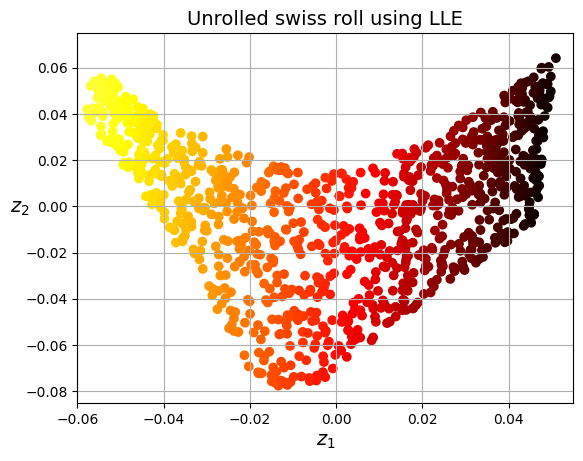

In [43]:
##### código extra – esta célula gera a Figura 7–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.06, 0.055, -0.085, 0.075])
plt.grid(True)


plt.title("Unrolled swiss roll using LLE")
plt.show()

O gráfico mostra o **Swiss Roll achatado em 2D**: a estrutura curva foi aberta e organizada, preservando a ordem natural dos pontos.  


- Comparamos a primeira coordenada obtida pelo LLE ($z_1$) com o parâmetro original $t$, que mede a posição dos pontos ao longo do Swiss Roll.  
- Um bom alinhamento entre $z_1$ e $t$ indica que o algoritmo conseguiu **recuperar a estrutura intrínseca** dos dados.  

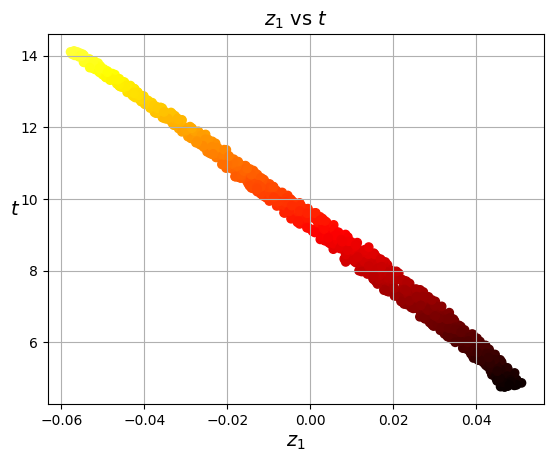

In [44]:
# código extra – mostra o quão bem correlacionado z1 está com t: LLE funcionou bem
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

O gráfico mostra que $z_1$ está fortemente correlacionado com $t$, confirmando que o **LLE funcionou bem** ao desenrolar o Swiss Roll.  


Nota: Adicionei `normalized_stress=False` abaixo para evitar um aviso sobre o fato de que o valor padrão para esse hiperparâmetro mudará no futuro. Consulte a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) para mais detalhes.

- Aplicamos o algoritmo **MDS (Escalonamento Multidimensional)** ao dataset Swiss Roll.  
- O MDS busca uma representação em **2 dimensões** preservando as **distâncias entre pontos** no espaço original.  
- Usamos `n_components=2` para reduzir para 2D e `random_state=42` para reprodutibilidade.  

In [45]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

c:\Users\estev\OneDrive\Área de Trabalho\NCIA\.ncia\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


O resultado é `X_reduced_mds`, uma versão em 2D do Swiss Roll onde o MDS tenta manter as distâncias originais, ainda que nem sempre consiga "desenrolar" perfeitamente a estrutura não linear.  


Nesta célula aplicamos duas técnicas de redução de dimensionalidade:  
- **Isomap**: combina vizinhança local com cálculo de distâncias geodésicas, conseguindo "desenrolar" superfícies curvas.  
- **t-SNE**: técnica não linear que preserva **relações de proximidade local**, muito usada para visualização em 2D de dados complexos.  
Ambos foram configurados para reduzir o Swiss Roll para 2 dimensões.  


In [46]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

O resultado são duas novas versões do Swiss Roll em 2D:  
- `X_reduced_isomap`: representação obtida pelo Isomap.  
- `X_reduced_tsne`: representação obtida pelo t-SNE.  
Ambas mostram como diferentes técnicas podem capturar a estrutura não linear dos dados de formas distintas.  


- Plotamos lado a lado os resultados de três métodos de redução de dimensionalidade aplicados ao Swiss Roll:  
  - **MDS**: preserva distâncias globais.  
  - **Isomap**: preserva distâncias geodésicas (ao longo da superfície curva).  
  - **t-SNE**: preserva bem as vizinhanças locais.  
- Cada método produz uma versão 2D do dataset colorida pela posição original `t`.  


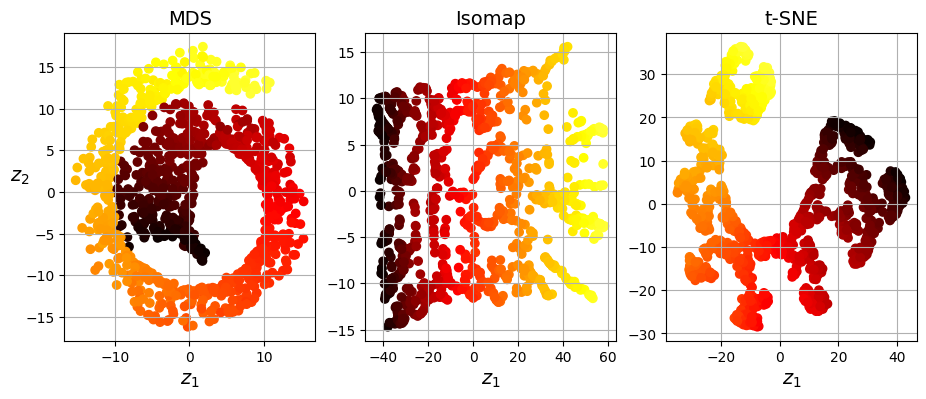

In [48]:
# código extra – esta célula gera a Figura 7–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)


plt.show()

O gráfico mostra como cada técnica projeta o Swiss Roll em 2D:  
- O **MDS** não desenrola bem a estrutura.  
- O **Isomap** recupera a forma esticada da superfície.  
- O **t-SNE** organiza os pontos preservando vizinhanças locais.  


# Material Extra – Kernel PCA

- Aplicamos **Kernel PCA**, uma extensão não linear do PCA, ao dataset Swiss Roll.  
- Testamos três funções de kernel:  
  - **Linear** (equivalente ao PCA tradicional).  
  - **RBF** (Radial Basis Function), capaz de desenrolar a superfície.  
  - **Sigmoid**, que se comporta de forma semelhante a uma rede neural simples.  
- Cada transformação reduz os dados para 2 dimensões e plota os pontos coloridos pela variável `t`.  

In [49]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

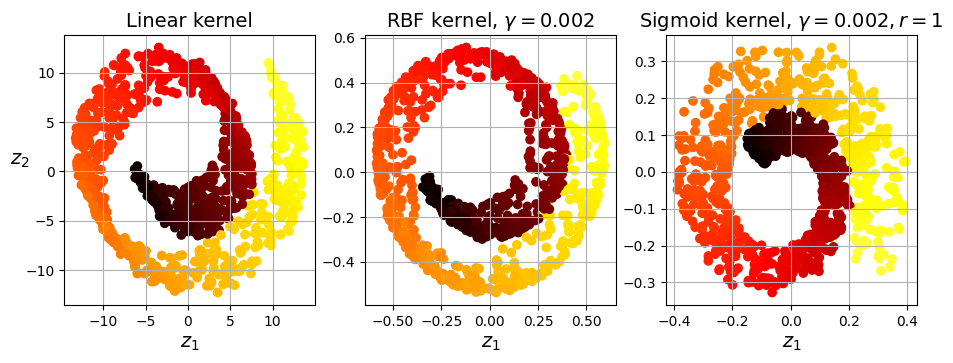

In [50]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()

O gráfico mostra como diferentes kernels afetam a projeção:  
- O **Linear kernel** não desenrola a estrutura.  
- O **RBF kernel** abre o Swiss Roll e recupera sua forma intrínseca.  
- O **Sigmoid kernel** gera uma transformação diferente, mas menos adequada para esse caso.  


![NCIA-end](NCIA_Images\end.png)